<a href="https://colab.research.google.com/github/MatteoGuglielmi-tech/Polarity-and-Subjectivity-Detection/blob/main/src/MyModel/BERT_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bert-Model


In [1]:
!nvidia-smi

Sat Nov  5 15:23:44 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [3]:
import pandas as pd 
import numpy as np 
import re

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import gc
from typing import Tuple, List
import torch.optim as opt
from tqdm import tqdm
import sys

In [4]:
def load_embeds(folder: str, kind: str)-> np.ndarray:
    output = np.load(root+f"BERT/{folder}/bert_emb_{kind}_100.npy")
    with tqdm(range(1,20), unit=' group') as tepoch:
        for i in tepoch:
            tmp = np.load(root+f"BERT/{folder}/bert_emb_{kind}_{(i+1)*100}.npy")
            output = np.concatenate((output,tmp))
            tepoch.set_postfix(dataset_length=len(output))
            gc.collect()
    return output

In [5]:
root = '/content/gdrive/MyDrive/Colab Notebooks/Polarity-Subjectivity-Detection/'

In [6]:
pol_embs = load_embeds(folder='Polarity-Embeddings-Truncated-Raw', kind='pol')

100%|██████████| 19/19 [00:16<00:00,  1.14 group/s, dataset_length=2000]


In [7]:
subj_embs = load_embeds(folder='Subjectivity-Embeddings-Truncated', kind='subj')

100%|██████████| 19/19 [00:15<00:00,  1.26 group/s, dataset_length=2000]


In [ ]:
print(subj_embs[0])
print(subj_embs.shape)
print(type(subj_embs))

[[-0.20552956 -0.31867674 -0.5099356  ... -0.16216797  0.40418056
   0.69566643]
 [ 0.6175808  -0.01059423 -0.35023454 ... -0.5969912   1.0701789
   0.3550825 ]
 [-0.5715393  -0.66713905 -0.15426251 ...  0.07675976  0.95184827
  -0.16426784]
 ...
 [-0.06158298 -0.15627947  0.12540703 ...  0.00730251  0.29697463
   0.4252466 ]
 [ 0.16194922 -0.36544093  0.09418974 ...  0.08095972  0.34186342
   0.48663992]
 [ 0.07279285 -0.14675184  0.11687171 ... -0.25037694  0.0810889
  -0.08667953]]
(2000, 45, 768)
<class 'numpy.ndarray'>


In [ ]:
print(len(subj_embs))

2000


In [ ]:
print(pol_embs[0].shape)
print(pol_embs[1999].shape)

(45, 768)
(45, 768)


In [ ]:
print(subj_embs[0].shape)
print(subj_embs[1999].shape)

(45, 768)
(45, 768)


In [8]:
gc.collect()
torch.cuda.empty_cache()

22

In [ ]:
print(len(pol_embs))
print(type(pol_embs))

2000
<class 'numpy.ndarray'>


In [ ]:
print(len(subj_embs))
print(type(subj_embs))

2000
<class 'numpy.ndarray'>


In [10]:
gc.collect()
torch.cuda.empty_cache()

## Train/Test split
Preparing the data to be fed to the model

In [11]:
pol_labels = np.array([1 if idx<1000 else 0 for idx in range(2000)])

In [12]:
pol_labels

array([1, 1, 1, ..., 0, 0, 0])

In [ ]:
pos = pol_labels[:1000]
neg = pol_labels[1000:]

In [ ]:
len(pos)

1000

In [ ]:
import torch
inp = torch.arange(1,16).reshape(5,3)
label = torch.randint(1,3,size=(5,))
print(inp)
print(label)

tensor([[ 1,  2,  3],
        [ 4,  5,  6],
        [ 7,  8,  9],
        [10, 11, 12],
        [13, 14, 15]])
tensor([2, 2, 2, 1, 1])


In [ ]:
from torch.utils.data import TensorDataset as td

ds = td(inp, label)
for inp, label in ds:
    print('{}:{}'.format(inp, label))

tensor([1, 2, 3]):2
tensor([4, 5, 6]):2
tensor([7, 8, 9]):2
tensor([10, 11, 12]):1
tensor([13, 14, 15]):1


In [ ]:
next(iter(ds))

(tensor([1, 2, 3]), tensor(2))

In [ ]:
len(neg)

1000

In [13]:
subj_labels = np.array([1 if idx<1000 else 0 for idx in range(2000)])

In [16]:
subj_labels

array([1, 1, 1, ..., 0, 0, 0])

In [17]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, RandomSampler
from torch.utils.data import TensorDataset as td


def get_data(pol_embs: np.array,
             subj_embs: np.array, 
             pol_labels: np.array, 
             subj_labels: np.array, 
             batch_size: int=128, 
             random_state=42, 
             test_split=0.2
             ) -> Tuple[torch.utils.data.DataLoader]:

    pol_train, pol_test, pol_labels_train, pol_labels_test = train_test_split(pol_embs, 
                                                                              pol_labels,
                                                                              test_size=test_split, 
                                                                              random_state=random_state)
    
    subj_train, subj_test, subj_labels_train, subj_labels_test = train_test_split(subj_embs, 
                                                                                  subj_labels,
                                                                                  test_size=test_split,
                                                                                  random_state=random_state)


    pol_train_tensor = torch.tensor(pol_train, requires_grad=True)
    pol_test_tensor = torch.tensor(pol_test, requires_grad=True)
    subj_train_tensor = torch.tensor(subj_train, requires_grad=True)
    subj_test_tensor = torch.tensor(subj_test, requires_grad=True)

    pol_train = td(pol_train_tensor, torch.tensor(pol_labels_train, dtype=torch.long))
    pol_test = td(pol_test_tensor, torch.tensor(pol_labels_test, dtype=torch.long))
    subj_train = td(subj_train_tensor, torch.tensor(subj_labels_train, dtype=torch.long))
    subj_test = td(subj_test_tensor, torch.tensor(subj_labels_test, dtype=torch.long))

    
    pol_train_loader = DataLoader(dataset=pol_train, 
                                  batch_size=batch_size,
                                  sampler=RandomSampler(pol_train)
                                  #shuffle=True
                                  )
    
    pol_test_loader = DataLoader(dataset=pol_test, 
                                 batch_size=batch_size,
                                 sampler=RandomSampler(pol_test) 
                                 #shuffle=True
                                 )

    subj_train_loader = DataLoader(dataset=subj_train, 
                                   batch_size=batch_size,
                                   sampler=RandomSampler(subj_train)
                                   #shuffle=True
                                   )
    
    subj_test_loader = DataLoader(dataset=subj_test,
                                  batch_size=batch_size,
                                  sampler=RandomSampler(subj_test) 
                                  #shuffle=True
                                  )
    
    return pol_train_loader, pol_test_loader, subj_train_loader, subj_test_loader

In [18]:
pol_train, pol_val, subj_train, subj_val = get_data(pol_embs=pol_embs, 
                                                    subj_embs=subj_embs,
                                                    pol_labels=pol_labels,
                                                    subj_labels=subj_labels,
                                                    batch_size=128)

In [19]:
for idx, (datum, label) in enumerate(pol_train):
    #print(f"Batch : {idx}\nTensor: {datum}{label}\n")
    print(f"Batch : {idx}, len batch: {len(datum)}")

Batch : 0, len batch: 128
Batch : 1, len batch: 128
Batch : 2, len batch: 128
Batch : 3, len batch: 128
Batch : 4, len batch: 128
Batch : 5, len batch: 128
Batch : 6, len batch: 128
Batch : 7, len batch: 128
Batch : 8, len batch: 128
Batch : 9, len batch: 128
Batch : 10, len batch: 128
Batch : 11, len batch: 128
Batch : 12, len batch: 64


In [20]:
for idx, (datum, label) in enumerate(subj_train):
    print(f"Batch : {idx}, len batch: {len(datum)}")

Batch : 0, len batch: 128
Batch : 1, len batch: 128
Batch : 2, len batch: 128
Batch : 3, len batch: 128
Batch : 4, len batch: 128
Batch : 5, len batch: 128
Batch : 6, len batch: 128
Batch : 7, len batch: 128
Batch : 8, len batch: 128
Batch : 9, len batch: 128
Batch : 10, len batch: 128
Batch : 11, len batch: 128
Batch : 12, len batch: 64


In [ ]:
data, labels = next(iter(subj_train))

In [ ]:
print(data[0])

In [ ]:
print(labels[0])

tensor(0)


## Model assembly

<center>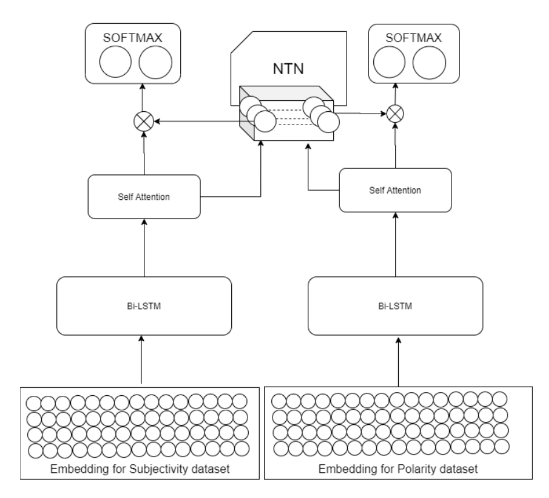</center>

<center>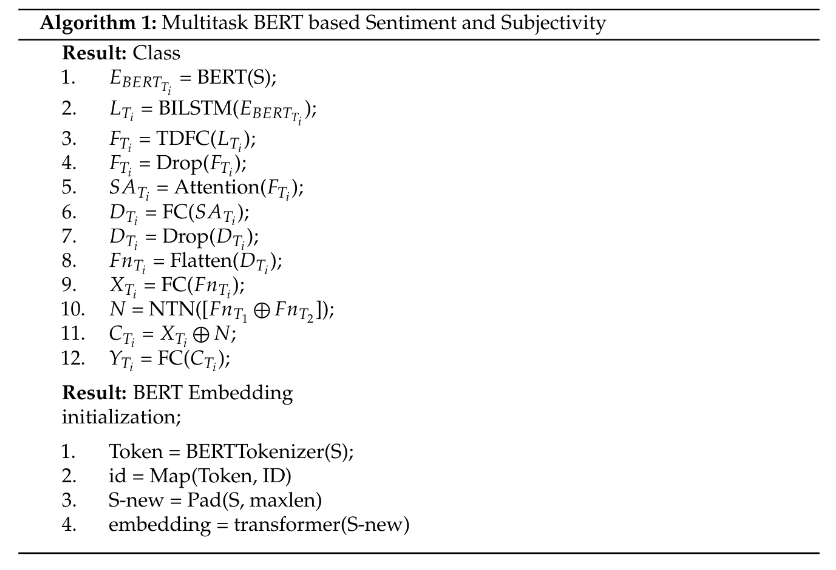</center>

In [90]:
def init_weights(mat):
    for m in mat.modules():
        if type(m) in [nn.GRU, nn.LSTM, nn.RNN]:
            for name, param in m.named_parameters():
                if 'weight_ih' in name:
                    for idx in range(4):
                        mul = param.shape[0]//4
                        torch.nn.init.xavier_uniform_(param[idx*mul:(idx+1)*mul])
                elif 'weight_hh' in name:
                    for idx in range(4):
                        mul = param.shape[0]//4
                        torch.nn.init.orthogonal_(param[idx*mul:(idx+1)*mul])
                elif 'bias' in name:
                    param.data.fill_(0)
        else:
            if type(m) in [nn.Linear]:
                torch.nn.init.uniform_(m.weight, -0.01, 0.01)
                if m.bias != None:
                    m.bias.data.fill_(0.01)

In [22]:
class TimeDistributedLayer(nn.Module):
    def __init__(self, module, batch_first=False):
        super(TimeDistributedLayer, self).__init__()
        self.module = module
        self.batch_first = batch_first

    def forward(self, x):

        if len(x.size()) <= 2:
            return self.module(x)

        # Squash samples and timesteps into a single axis
        x_reshape = x.contiguous().view(-1, x.size(-1))  # (samples * timesteps, input_size)

        y = self.module(x_reshape)

        # We have to reshape Y
        if self.batch_first:
            y = y.contiguous().view(x.size(0), -1, y.size(-1))  # (samples, timesteps, output_size)
        else:
            y = y.view(-1, x.size(1), y.size(-1))  # (timesteps, samples, output_size)

        return y

In [23]:
class NeuralTensorNetwork(nn.Module):
    def __init__(self, 
                 output_dim: int, 
                 input_dim: int, 
                 activation: str="tanh",
                 mean: float=0.0, 
                 std: float=1.0
                 ) -> None:
        
        super(NeuralTensorNetwork, self).__init__()

        # setting input and output dimensions
        self.k = output_dim
        self.d = input_dim # e1,e2

        # setting mean and std for random initialization
        self.mean = mean
        self.std = std

        self.activation = activation

        # parameters has been used in order to consider W, V, b as model parameters
        # inference -> they'll be optimized

        # normal sampling -> https://pytorch.org/docs/stable/generated/torch.normal.html
        # parameter -> https://pytorch.org/docs/stable/generated/torch.nn.parameter.Parameter.html#torch.nn.parameter.Parameter
        self.W = nn.Parameter(torch.normal(self.mean, self.std, size=(self.k, 
                                                                      self.d, 
                                                                      self.d)))
        self.V = nn.Parameter(torch.normal(self.mean, self.std, size=(2*self.d, 
                                                                      self.k)))
        self.b = nn.Parameter(torch.zeros(size=(self.d,)))
        
        if activation == 'tanh':
            self.activation = nn.Tanh()
        elif activation == 'sigmoid':
            self.activation = nn.Sigmoid()
        elif self.activation == 'relu':
            self.activation = nn.ReLU()
        # checking for a good activation function
        else:
            raise ValueError('Possible activation choices are tanh, sigmoid or ReLU')

    def forward(self, inputs: List[torch.Tensor]) -> torch.Tensor:
        if type(inputs) is not list or len(inputs) <= 1:
            raise Exception('BilinearTensorLayer must be called on a list of tensors '
                      '(at least 2). Got: ' + str(inputs))

        # getting the entities
        e1 = inputs[0]
        e2 = inputs[1]

        with torch.no_grad():
            e1_clone = torch.clone(e1)
            batch_size = e1_clone.size(dim=0) #torch.clone(e1).detach().numpy().shape[0]

        #batch_size = self.batch_size
        k = self.k
        d = self.d

        # bilinear tensor + bias
        bil_bias = [torch.sum((e2 * torch.matmul(e1, self.W[0])) + self.b, 
                              axis=1)]
        
        for i in range(1,k):
            bil_bias.append(torch.sum((e2*torch.matmul(e1, self.W[i])) + self.b, 
                                      axis=1))
        
        bil_bias = torch.cat(bil_bias, axis=0)
        bil_bias = torch.reshape(bil_bias, (batch_size, k))

        # Vr * [e1, e2]
        rest = torch.matmul(torch.cat([e1,e2], dim=1), self.V)

        e1_R_e2 = bil_bias + rest

        # applying activation
        f = self.activation(e1_R_e2)

        return f

In [24]:
class Attention(nn.Module):
    """ Applies attention mechanism on the `context` using the `query`.

    **Thank you** to IBM for their initial implementation of :class:`Attention`. Here is
    their `License
    <https://github.com/IBM/pytorch-seq2seq/blob/master/LICENSE>`__.

    Args:
        dimensions (int): Dimensionality of the query and context.
        attention_type (str, optional): How to compute the attention score:

            * dot: :math:`score(H_j,q) = H_j^T q`
            * general: :math:`score(H_j, q) = H_j^T W_a q`
    """

    def __init__(self, dimensions, attention_type='general'):
        super(Attention, self).__init__()

        if attention_type not in ['dot', 'general']:
            raise ValueError('Invalid attention type selected.')

        self.attention_type = attention_type
        if self.attention_type == 'general':
            self.linear_in = nn.Linear(dimensions, dimensions, bias=False)

        self.linear_out = nn.Linear(dimensions * 2, dimensions, bias=False)
        self.softmax = nn.Softmax(dim=-1)
        self.tanh = nn.Tanh()

    def forward(self, query, context):
        """
        Args:
            query (:class:`torch.FloatTensor` [batch size, output length, dimensions]): Sequence of
                queries to query the context.
            context (:class:`torch.FloatTensor` [batch size, query length, dimensions]): Data
                overwhich to apply the attention mechanism.

        Returns:
            :class:`tuple` with `output` and `weights`:
            * **output** (:class:`torch.LongTensor` [batch size, output length, dimensions]):
              Tensor containing the attended features.
            * **weights** (:class:`torch.FloatTensor` [batch size, output length, query length]):
              Tensor containing attention weights.
        """
        batch_size, output_len, dimensions = query.size()
        query_len = context.size(1)

        if self.attention_type == "general":
            query = query.reshape(batch_size * output_len, dimensions)
            query = self.linear_in(query)
            query = query.reshape(batch_size, output_len, dimensions)

        # (batch_size, output_len, dimensions) * (batch_size, query_len, dimensions) ->
        # (batch_size, output_len, query_len)
        attention_scores = torch.bmm(query, context.transpose(1, 2).contiguous())

        # Compute weights across every context sequence
        attention_scores = attention_scores.view(batch_size * output_len, query_len)
        attention_weights = self.softmax(attention_scores)
        attention_weights = attention_weights.view(batch_size, output_len, query_len)

        # (batch_size, output_len, query_len) * (batch_size, query_len, dimensions) ->
        # (batch_size, output_len, dimensions)
        mix = torch.bmm(attention_weights, context)

        # concat -> (batch_size * output_len, 2*dimensions)
        combined = torch.cat((mix, query), dim=2)
        combined = combined.view(batch_size * output_len, 2 * dimensions)

        # Apply linear_out on every 2nd dimension of concat
        # output -> (batch_size, output_len, dimensions)
        output = self.linear_out(combined).view(batch_size, output_len, dimensions)
        output = self.tanh(output)

        return output, attention_weights

In [70]:
class MTL(nn.Module):
    def __init__(self):
        super(MTL, self).__init__()

        # BiLSTMs
        # https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html
        self.lstm1 = nn.LSTM(input_size=768, hidden_size=128, batch_first=True, 
                             bidirectional=True)
        self.lstm2 = nn.LSTM(input_size=768, hidden_size=128, batch_first=True,
                             bidirectional=True)

        # TimeDistributed
        self.dense1 = TimeDistributedLayer(
            nn.Sequential(
                nn.Linear(in_features=256, out_features=128),
                nn.ReLU()
            )
        )

        self.dense2 = TimeDistributedLayer(
            nn.Sequential(
                nn.Linear(in_features=256, out_features=128),
                nn.ReLU()
            )
        )

        # dropout layers
        self.drop1 = nn.Dropout(p=0.5, inplace=False)
        self.drop2 = nn.Dropout(p=0.5, inplace=False)

        ## https://pytorch.org/docs/stable/generated/torch.nn.MultiheadAttention.html
        #self.attention1 = nn.MultiheadAttention(embed_dim=128, num_heads=num_heads)
        #self.attention2 = nn.MultiheadAttention(embed_dim=128, num_heads=num_heads)

        #self.attention1 = Attention(dimensions=128, attention_type='general')
        #self.attention2 = Attention(dimensions=128, attention_type='general')

        # Dense Layers
        self.dense12 = nn.Sequential(
            nn.Linear(in_features=128, out_features=10),
            nn.ReLU()
        )

        self.dense22 = nn.Sequential(
            nn.Linear(in_features=128, out_features=10),
            nn.ReLU()
        )

        # dropout
        self.drop3 = nn.Dropout(p=0.5, inplace=False)
        self.drop4 = nn.Dropout(p=0.5, inplace=False)

        # flattening layer
        self.flat1 = nn.Flatten()
        self.flat2 = nn.Flatten()

        # Neural Tensor Layer
        self.ntn = NeuralTensorNetwork(output_dim=64, input_dim=450)

        # Dense
        self.flat11 = nn.Sequential(
            nn.Linear(in_features=450, out_features=50),
            nn.ReLU()
        )
        self.flat22 = nn.Sequential(
            nn.Linear(in_features=450, out_features=50),
            nn.ReLU()
        )

        # final layers (the softmax will be applied at the end by the loss)
        self.pred1 = nn.Linear(in_features=114, out_features=2)
        self.pred2 = nn.Linear(in_features=114, out_features=2)


    def forward(self, emb1, emb2) -> Tuple[torch.Tensor, torch.Tensor]:

        # https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html
        pol_out, _ = self.lstm1(emb1)
        #pol_hidden = torch.cat((pol_out[:,-1,:128], pol_out[:,0,128:]), dim=1)
        
        subj_out, _ = self.lstm2(emb2)
        #subj_hidden = torch.cat((subj_out[:,-1,:128], subj_out[:,0,128:]), dim=1)

        #pol = self.dense1(pol_hidden.view(-1, 128*2))
        #subj = self.dense2(subj_hidden.view(-1, 128*2))

        pol = self.dense1(pol_out)
        subj = self.dense2(subj_out)

        drop1 = self.drop1(pol)
        drop2 = self.drop2(subj)

        ## https://stackoverflow.com/questions/65642832/inputs-to-the-nn-multiheadattention
        #attn_out1, _ = self.attention1(query=pol_q, key=pol_k, value=pol_v)
        #attn_out2, _ = self.attention2(query=subj_q, key=subj_k, value=subj_v)

        #attn_out1, _ = self.attention1(query=drop1, context=drop1)
        #attn_out2, _ = self.attention1(query=drop2, context=drop2)

        pol_dense = self.dense12(drop1)
        subj_dense = self.dense22(drop2)

        drop3 = self.drop3(pol_dense)
        drop4 = self.drop4(subj_dense)

        pol_flat = self.flat1(drop3)
        subj_flat = self.flat2(drop4)

        ntn_output = self.ntn([pol_flat, subj_flat])

        pol_flat1 = self.flat11(pol_flat)
        subj_flat1 = self.flat22(subj_flat)

        pol_merged = torch.concat((pol_flat1, ntn_output), dim=1)
        subj_merged = torch.concat((subj_flat1, ntn_output), dim=1)

        pol_out = self.pred1(pol_merged)
        subj_out = self.pred2(subj_merged)

        return pol_out, subj_out

In [34]:
def cross_entropy_loss():
    loss = torch.nn.CrossEntropyLoss()
    return loss

In [98]:
def get_optimizer(net, lr: float=0.2):
    return torch.optim.Adam(net.parameters(), lr=lr, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)
    #return torch.optim.SGD(net.parameters(), lr=lr, weight_decay=0.000001, momentum=0.9)

In [38]:
from matplotlib.lines import Line2D

In [81]:
def plot_grad_flow(named_parameters):
    '''Plots the gradients flowing through different layers in the net during training.
    Can be used for checking for possible gradient vanishing / exploding problems.
    
    Usage: Plug this function in Trainer class after loss.backwards() as 
    "plot_grad_flow(self.model.named_parameters())" to visualize the gradient flow'''
    ave_grads = []
    max_grads= []
    layers = []
    for n, p in named_parameters:
        if(p.requires_grad) and ("bias" not in n):
            #print(p.grad, n)
            layers.append(n)
            ave_grads.append(p.grad.abs().mean().cpu())                         # moving data to CPU to accomodate plt
            max_grads.append(p.grad.abs().max().cpu())                          
    plt.bar(np.arange(len(max_grads)), max_grads, alpha=0.1, lw=1, color="c")
    plt.bar(np.arange(len(max_grads)), ave_grads, alpha=0.1, lw=1, color="b")
    plt.hlines(0, 0, len(ave_grads)+1, lw=2, color="k" )
    plt.xticks(range(0,len(ave_grads), 1), layers, rotation="vertical")
    plt.xlim(left=0, right=len(ave_grads))
    plt.ylim(bottom = -0.001, top=0.02) # zoom in on the lower gradient regions
    plt.xlabel("Layers")
    plt.ylabel("average gradient")
    plt.title("Gradient flow")
    plt.grid(True)
    plt.legend([Line2D([0], [0], color="c", lw=4),
                Line2D([0], [0], color="b", lw=4),
                Line2D([0], [0], color="k", lw=4)], ['max-gradient', 'mean-gradient', 'zero-gradient'])


In [101]:
def training_step(model, 
                  pol_train: torch.utils.data.DataLoader, 
                  sub_train: torch.utils.data.DataLoader, 
                  cost_function : torch.nn.modules.loss, 
                  optimizer : torch.optim, 
                  device: str='cuda:0', 
                  batch_size: int=128
                  ) -> None: #-> Tuple[float]:
    
    samples = 0.

    cumulative_pol_accuracy = 0.
    cumulative_subj_accuracy = 0.

    cumulative_pol_loss = 0.
    cumulative_subj_loss = 0.
    total_cumulative_loss = 0.

    model.train()

    subj_train_iter = iter(sub_train)

    # iterate over the training set
    #for batch_idx, (pol_tensor, pol_label) in enumerate(pol_train):
    with tqdm(pol_train, unit="batch") as tepoch: 
        for batch_idx, (pol_tensor, pol_label) in enumerate(tepoch):
            
            tepoch.set_description(f"# Batch : {batch_idx}")

            # load polarity data to GPU
            pol_inputs = pol_tensor.to(device)
            pol_labels = pol_label.to(device)#.to(torch.long)

            # load subjectivity data to GPU
            subj_inputs, subj_labels = next(subj_train_iter)
            subj_inputs = subj_inputs.to(device)
            subj_labels = subj_labels.to(device)#.to(torch.long)
        
            # forward pass -> the output should be two vecotors.
            # as a consequence two losses
            pol_out, subj_out = model(pol_inputs, subj_inputs)

            # loss computation
            pol_loss = cost_function(pol_out, pol_labels)
            sub_loss = cost_function(subj_out, subj_labels)

            total_cumulative_loss = pol_loss + sub_loss

            total_cumulative_loss.backward()

            plot_grad_flow(model.named_parameters())
        
            # parameters update
            optimizer.step()

            # fetch prediction and loss value for polarity 
            samples += pol_inputs.shape[0]
            _, predicted_pol = pol_out.max(dim=1)
            _, predicted_subj = subj_out.max(dim=1)

            ## compute training accuracies
            cumulative_pol_accuracy += predicted_pol.eq(pol_labels).sum().item()
            cumulative_subj_accuracy += predicted_subj.eq(subj_labels).sum().item()

            tepoch.set_postfix(loss=total_cumulative_loss.item(), 
                               pol_loss = pol_loss.item(), 
                               subj_loss=sub_loss.item(), 
                               pol_accuracy=100.*(cumulative_pol_accuracy/samples), 
                               subj_accuracy=100.*(cumulative_subj_accuracy/samples),
                               samples_w_batch=samples)
        
            # gradients reset
            optimizer.zero_grad()

    #epoch_loss = total_cumulative_loss/(batch_idx+1)
        
    #return total_cumulative_loss,(cumulative_pol_accuracy/samples)*100, (cumulative_subj_accuracy/samples)*100

In [29]:
def test_step(model, 
              pol_test: torch.utils.data.DataLoader, 
              subj_test: torch.utils.data.DataLoader, 
              cost_function : torch.nn.modules.loss,
              device: str='cuda:0'
              ) -> Tuple[float]:

    samples = 0.

    cumulative_pol_accuracy = 0.
    cumulative_subj_accuracy = 0.

    total_cumulative_loss = 0.

    model.eval()
    subj_test_iter = iter(subj_test)

    with torch.no_grad():
        
        for batch_idx, (pol_tensor, pol_label) in enumerate(pol_test):

            #print(pol_tensor.size())# -> torch.Size([64, 64, 768])
            #print(pol_label.size())# -> [64]

            # load polarity data to GPU
            pol_inputs = pol_tensor.to(device)
            pol_labels = pol_label.to(device)#.to(torch.long)

            # print(subj_inputs.size()) -> torch.Size([64, 64, 768])
            # print(subj_labels.size()) -> [64]

            # load subjectivity data to GPU
            subj_inputs, subj_labels = next(subj_test_iter)
            subj_inputs = subj_inputs.to(device)
            subj_labels = subj_labels.to(device)#.to(torch.long)

            # forward pass -> the output should be two vecotors.
            # as a consequence two losses
            pol_out, subj_out = model(pol_inputs, subj_inputs)

            #print(pol_out.size()) -> torch.Size([64,2])
            #print(subj_out.size()) -> torch.Size([64,2])

            # apply the loss
            pol_loss = cost_function(pol_out, pol_labels)
            sub_loss = cost_function(subj_out, subj_labels)
        
            # fetch prediction and loss value for polarity 
            samples_pol += pol_inputs.shape[0]
            #cumulative_pol_loss += pol_loss.item()
            _, predicted_pol = pol_out.max(dim=1) # max() returns (maximum_value, index_of_maximum_value)

            # compute training accuracy
            cumulative_pol_accuracy += predicted_pol.eq(pol_labels).sum().item()
        
            # fetch prediction and loss value for subjectivity dataset
            samples_subj += subj_inputs.shape[0]
            #cumulative_subj_loss += sub_loss.item()
            _, predicted_sub = subj_out.max(dim=1) # max() returns (maximum_value, index_of_maximum_value)

            # compute training accuracy
            cumulative_subj_accuracy += predicted_sub.eq(subj_labels).sum().item()

    return cumulative_pol_loss,(cumulative_pol_accuracy/samples_pol)*100, cumulative_subj_loss/samples_subj, (cumulative_subj_accuracy/samples_subj)*100    

In [30]:
# tensorboard logging utilities
def log_values(writer, step, loss, accuracy, prefix):
  writer.add_scalar(f"{prefix}/loss", loss, step)
  writer.add_scalar(f"{prefix}/accuracy", accuracy, step)

In [85]:
def print_net_parameters(model) -> None:
    for name, param in model.named_parameters():
        if param.requires_grad:
            print(name, param.data)

In [93]:
def init_model(model):
    for param in model.parameters():
        param.requires_grad = True
    
    model=model.apply(init_weights)
    
    return model

In [94]:
def main(
         pol_embs: np.array, 
         subj_embs: np.array,
         pol_labels: np.array,
         subj_labels: np.array,
         batch_size: int=128,
         device: str='cuda:0',
         epochs: int=30,
         pr: bool=False
         ) -> Tuple[float]:
  
  
    net = MTL().to(device)
    net = init_model(net)

    #print(list(net.parameters())) -> confirms that network parameters have gradient enabled

    #print(net) -> uncomment to see the network layout

    if pr:
        print_net_parameters(net)

    print('Network Init Done')

    cost_function = cross_entropy_loss()

    print('Got Loss')

    optimizer = get_optimizer(net)

    print("Got Optimizer")

    pol_train_loader, pol_val_loader, subj_train_loader, subj_val_loader = get_data(pol_embs=pol_embs, 
                                                                                    subj_embs=subj_embs,
                                                                                    pol_labels=pol_labels,
                                                                                    subj_labels=subj_labels,
                                                                                    batch_size=batch_size)

    print("Got Dataloaders")

    for e in range(epochs):

        print(f"Epoch {e}:\t")

        #train_loss, pol_train_accuracy, subj_train_accuracy = 
        training_step(model=net,
                      pol_train=pol_train_loader, 
                      sub_train=subj_train_loader, 
                      cost_function=cost_function, 
                      optimizer=optimizer, 
                      device=device)

        #print(f"Training loss: {train_loss}\nPolarity training accuracy: {pol_train_accuracy}\nSubjectivity training accuracy: {subj_train_accuracy}")

## Hyperparameters

In [32]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [64]:
main(pol_embs=pol_embs, subj_embs=subj_embs, pol_labels=pol_labels, subj_labels=subj_labels, device=device)

Network Init Done
Got Loss
Got Optimizer
1600
Got Dataloaders
Epoch 0:	


# Batch : 12: 100%|██████████| 13/13 [07:31<00:00, 34.72s/samples, loss=1.17, pol_accuracy=51.7, pol_loss=0.672, samples=1600.0, samples_w_batch=1664, subj_accuracy=76.6, subj_loss=0.498]


Epoch 1:	


# Batch : 12: 100%|██████████| 13/13 [07:03<00:00, 32.56s/samples, loss=0.923, pol_accuracy=52.1, pol_loss=0.713, samples=1600.0, samples_w_batch=1664, subj_accuracy=89.3, subj_loss=0.211]


Epoch 2:	


# Batch : 12: 100%|██████████| 13/13 [06:49<00:00, 31.50s/samples, loss=0.895, pol_accuracy=50.6, pol_loss=0.699, samples=1600.0, samples_w_batch=1664, subj_accuracy=93.2, subj_loss=0.196]


Epoch 3:	


# Batch : 12: 100%|██████████| 13/13 [06:48<00:00, 31.45s/samples, loss=0.9, pol_accuracy=48.1, pol_loss=0.718, samples=1600.0, samples_w_batch=1664, subj_accuracy=93.2, subj_loss=0.182]


Epoch 4:	


# Batch : 12: 100%|██████████| 13/13 [06:47<00:00, 31.35s/samples, loss=0.806, pol_accuracy=50.3, pol_loss=0.689, samples=1600.0, samples_w_batch=1664, subj_accuracy=96.3, subj_loss=0.117]


Epoch 5:	


# Batch : 12: 100%|██████████| 13/13 [06:46<00:00, 31.29s/samples, loss=0.738, pol_accuracy=50.1, pol_loss=0.691, samples=1600.0, samples_w_batch=1664, subj_accuracy=96.6, subj_loss=0.047]


Epoch 6:	


# Batch : 12: 100%|██████████| 13/13 [06:41<00:00, 30.89s/samples, loss=0.796, pol_accuracy=48.3, pol_loss=0.699, samples=1600.0, samples_w_batch=1664, subj_accuracy=96.9, subj_loss=0.0974]


Epoch 7:	


# Batch : 12: 100%|██████████| 13/13 [06:29<00:00, 29.96s/samples, loss=0.716, pol_accuracy=48.5, pol_loss=0.701, samples=1600.0, samples_w_batch=1664, subj_accuracy=97.1, subj_loss=0.0151]


Epoch 8:	


# Batch : 12: 100%|██████████| 13/13 [06:28<00:00, 29.85s/samples, loss=0.782, pol_accuracy=52.2, pol_loss=0.695, samples=1600.0, samples_w_batch=1664, subj_accuracy=97.6, subj_loss=0.0871]


Epoch 9:	


# Batch : 12: 100%|██████████| 13/13 [06:32<00:00, 30.20s/samples, loss=0.86, pol_accuracy=52.2, pol_loss=0.706, samples=1600.0, samples_w_batch=1664, subj_accuracy=96.6, subj_loss=0.155]


Epoch 10:	


# Batch : 12: 100%|██████████| 13/13 [06:33<00:00, 30.29s/samples, loss=0.791, pol_accuracy=47.2, pol_loss=0.698, samples=1600.0, samples_w_batch=1664, subj_accuracy=97.9, subj_loss=0.0936]


Epoch 11:	


# Batch : 12: 100%|██████████| 13/13 [06:28<00:00, 29.90s/samples, loss=0.775, pol_accuracy=49.8, pol_loss=0.684, samples=1600.0, samples_w_batch=1664, subj_accuracy=94.7, subj_loss=0.0907]


Epoch 12:	


# Batch : 12: 100%|██████████| 13/13 [06:28<00:00, 29.85s/samples, loss=0.827, pol_accuracy=49.6, pol_loss=0.693, samples=1600.0, samples_w_batch=1664, subj_accuracy=96.5, subj_loss=0.134]


Epoch 13:	


# Batch : 12: 100%|██████████| 13/13 [06:27<00:00, 29.82s/samples, loss=0.897, pol_accuracy=50.3, pol_loss=0.695, samples=1600.0, samples_w_batch=1664, subj_accuracy=97.7, subj_loss=0.202]


Epoch 14:	


# Batch : 12: 100%|██████████| 13/13 [06:27<00:00, 29.83s/samples, loss=0.748, pol_accuracy=49.2, pol_loss=0.691, samples=1600.0, samples_w_batch=1664, subj_accuracy=97.2, subj_loss=0.0565]


Epoch 15:	


# Batch : 12: 100%|██████████| 13/13 [06:27<00:00, 29.83s/samples, loss=0.716, pol_accuracy=48.4, pol_loss=0.706, samples=1600.0, samples_w_batch=1664, subj_accuracy=98, subj_loss=0.0106]


Epoch 16:	


# Batch : 12: 100%|██████████| 13/13 [06:28<00:00, 29.85s/samples, loss=0.695, pol_accuracy=49.9, pol_loss=0.686, samples=1600.0, samples_w_batch=1664, subj_accuracy=97.6, subj_loss=0.00924]


Epoch 17:	


# Batch : 12: 100%|██████████| 13/13 [06:27<00:00, 29.77s/samples, loss=0.78, pol_accuracy=49.1, pol_loss=0.686, samples=1600.0, samples_w_batch=1664, subj_accuracy=97, subj_loss=0.0944]


Epoch 18:	


# Batch : 12: 100%|██████████| 13/13 [06:27<00:00, 29.82s/samples, loss=0.837, pol_accuracy=50.5, pol_loss=0.691, samples=1600.0, samples_w_batch=1664, subj_accuracy=96.4, subj_loss=0.145]


Epoch 19:	


# Batch : 12: 100%|██████████| 13/13 [06:30<00:00, 30.07s/samples, loss=0.752, pol_accuracy=47.5, pol_loss=0.702, samples=1600.0, samples_w_batch=1664, subj_accuracy=96.9, subj_loss=0.0498]


Epoch 20:	


# Batch : 12: 100%|██████████| 13/13 [06:27<00:00, 29.81s/samples, loss=0.879, pol_accuracy=51, pol_loss=0.694, samples=1600.0, samples_w_batch=1664, subj_accuracy=96.4, subj_loss=0.185]


Epoch 21:	


# Batch : 12: 100%|██████████| 13/13 [06:27<00:00, 29.82s/samples, loss=0.985, pol_accuracy=51, pol_loss=0.698, samples=1600.0, samples_w_batch=1664, subj_accuracy=96.2, subj_loss=0.287]


Epoch 22:	


# Batch : 12: 100%|██████████| 13/13 [06:28<00:00, 29.85s/samples, loss=0.805, pol_accuracy=50.2, pol_loss=0.694, samples=1600.0, samples_w_batch=1664, subj_accuracy=96.9, subj_loss=0.111]


Epoch 23:	


# Batch : 12: 100%|██████████| 13/13 [06:26<00:00, 29.75s/samples, loss=1.1, pol_accuracy=48.4, pol_loss=0.694, samples=1600.0, samples_w_batch=1664, subj_accuracy=91.3, subj_loss=0.402]


Epoch 24:	


# Batch : 12: 100%|██████████| 13/13 [06:28<00:00, 29.86s/samples, loss=0.722, pol_accuracy=49.8, pol_loss=0.687, samples=1600.0, samples_w_batch=1664, subj_accuracy=92.7, subj_loss=0.035]


Epoch 25:	


# Batch : 12: 100%|██████████| 13/13 [06:26<00:00, 29.71s/samples, loss=0.748, pol_accuracy=51, pol_loss=0.69, samples=1600.0, samples_w_batch=1664, subj_accuracy=94.2, subj_loss=0.0587]


Epoch 26:	


# Batch : 12: 100%|██████████| 13/13 [06:27<00:00, 29.84s/samples, loss=0.83, pol_accuracy=49, pol_loss=0.702, samples=1600.0, samples_w_batch=1664, subj_accuracy=95.7, subj_loss=0.128]


Epoch 27:	


# Batch : 12: 100%|██████████| 13/13 [06:25<00:00, 29.67s/samples, loss=0.781, pol_accuracy=47.8, pol_loss=0.698, samples=1600.0, samples_w_batch=1664, subj_accuracy=97.1, subj_loss=0.0827]


Epoch 28:	


# Batch : 12: 100%|██████████| 13/13 [06:29<00:00, 29.97s/samples, loss=0.914, pol_accuracy=47.8, pol_loss=0.719, samples=1600.0, samples_w_batch=1664, subj_accuracy=95.5, subj_loss=0.195]


Epoch 29:	


# Batch : 12: 100%|██████████| 13/13 [06:28<00:00, 29.88s/samples, loss=0.742, pol_accuracy=50.9, pol_loss=0.699, samples=1600.0, samples_w_batch=1664, subj_accuracy=96.2, subj_loss=0.0428]


In [ ]:
main(pol_embs=pol_embs, subj_embs=subj_embs, pol_labels=pol_labels, subj_labels=subj_labels, device=device, pr=True)

Network Init Done
Got Loss
Got Optimizer
Got Dataloaders
Epoch 0:	


# Batch : 12: 100%|██████████| 13/13 [06:01<00:00, 27.78s/batch, loss=3.08, pol_accuracy=51, pol_loss=1.6, samples_w_batch=1600.0, subj_accuracy=52.6, subj_loss=1.47]


Epoch 1:	


# Batch : 12: 100%|██████████| 13/13 [05:43<00:00, 26.45s/batch, loss=1.4, pol_accuracy=51.8, pol_loss=0.698, samples_w_batch=1600.0, subj_accuracy=49.7, subj_loss=0.704]


Epoch 2:	


# Batch : 12: 100%|██████████| 13/13 [05:53<00:00, 27.20s/batch, loss=2.14, pol_accuracy=49.1, pol_loss=1.47, samples_w_batch=1600.0, subj_accuracy=51.1, subj_loss=0.666]


Epoch 3:	


# Batch : 12: 100%|██████████| 13/13 [05:53<00:00, 27.19s/batch, loss=2.79, pol_accuracy=49.4, pol_loss=2.04, samples_w_batch=1600.0, subj_accuracy=49.1, subj_loss=0.752]


Epoch 4:	


# Batch : 12: 100%|██████████| 13/13 [05:39<00:00, 26.13s/batch, loss=1.64, pol_accuracy=51.2, pol_loss=0.768, samples_w_batch=1600.0, subj_accuracy=49.9, subj_loss=0.873]


Epoch 5:	


# Batch : 12: 100%|██████████| 13/13 [05:27<00:00, 25.16s/batch, loss=2.49, pol_accuracy=52.2, pol_loss=1.37, samples_w_batch=1600.0, subj_accuracy=49.8, subj_loss=1.12]


Epoch 6:	


# Batch : 12: 100%|██████████| 13/13 [05:26<00:00, 25.12s/batch, loss=2.18, pol_accuracy=51, pol_loss=1.18, samples_w_batch=1600.0, subj_accuracy=50.1, subj_loss=1]


Epoch 7:	


# Batch : 12: 100%|██████████| 13/13 [05:26<00:00, 25.09s/batch, loss=1.6, pol_accuracy=49.6, pol_loss=0.765, samples_w_batch=1600.0, subj_accuracy=50.1, subj_loss=0.838]


Epoch 8:	


# Batch : 12: 100%|██████████| 13/13 [05:25<00:00, 25.06s/batch, loss=1.84, pol_accuracy=50.3, pol_loss=0.762, samples_w_batch=1600.0, subj_accuracy=49.3, subj_loss=1.07]


Epoch 9:	


# Batch : 12: 100%|██████████| 13/13 [05:25<00:00, 25.05s/batch, loss=1.44, pol_accuracy=49.9, pol_loss=0.719, samples_w_batch=1600.0, subj_accuracy=53.6, subj_loss=0.724]


Epoch 10:	


# Batch : 12: 100%|██████████| 13/13 [05:22<00:00, 24.84s/batch, loss=1.57, pol_accuracy=49.8, pol_loss=0.808, samples_w_batch=1600.0, subj_accuracy=49.6, subj_loss=0.758]


Epoch 11:	


# Batch : 12: 100%|██████████| 13/13 [05:19<00:00, 24.57s/batch, loss=1.44, pol_accuracy=49.3, pol_loss=0.737, samples_w_batch=1600.0, subj_accuracy=49.5, subj_loss=0.7]


Epoch 12:	


# Batch : 12: 100%|██████████| 13/13 [05:18<00:00, 24.52s/batch, loss=1.5, pol_accuracy=49, pol_loss=0.72, samples_w_batch=1600.0, subj_accuracy=49.4, subj_loss=0.783]


Epoch 13:	


# Batch : 12: 100%|██████████| 13/13 [05:19<00:00, 24.56s/batch, loss=1.39, pol_accuracy=50.3, pol_loss=0.681, samples_w_batch=1600.0, subj_accuracy=49.6, subj_loss=0.712]


Epoch 14:	


# Batch : 12: 100%|██████████| 13/13 [05:19<00:00, 24.55s/batch, loss=1.49, pol_accuracy=52.3, pol_loss=0.79, samples_w_batch=1600.0, subj_accuracy=51.3, subj_loss=0.701]


Epoch 15:	


# Batch : 8:  62%|██████▏   | 8/13 [03:24<02:07, 25.48s/batch, loss=1.57, pol_accuracy=49.2, pol_loss=0.692, samples_w_batch=1024.0, subj_accuracy=50.7, subj_loss=0.876]

In [96]:
gc.collect()

159298

In [97]:
torch.cuda.empty_cache()

## Tensorflow

In [ ]:
!pip install keras-self-attention

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for keras-self-attention: filename=keras_self_attention-0.51.0-py3-none-any.whl size=18912 sha256=d71a308b650e0c6571644e6e2f2d1c5bf83334be15488b9573be8cd170797447
  Stored in directory: /root/.cache/pip/wheels/95/b1/a8/5ee00cc137940b2f6fa198212e8f45d813d0e0d9c3a04035a3
Successfully built keras-self-attention


In [ ]:
import sys
import keras
import numpy as np
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold
import io
from keras.utils import pad_sequences
import pandas as pd
import csv
from keras.layers import Input
from keras.layers import Concatenate
import scipy.stats as stats
from keras import backend as K
from keras.layers.core import Lambda
from keras.layers import Layer
from keras.models import Sequential
from keras.layers import Input,Dense,GRU,LSTM,Concatenate,Dropout,Activation,Add, Masking, Concatenate, Dot, RepeatVector, Permute, Multiply, Dense
from keras.layers.pooling import AveragePooling1D,MaxPooling1D
from keras.layers.core import Flatten
from keras.callbacks import EarlyStopping
from keras.layers.convolutional import Conv1D, Conv2D
from keras.models import Model
from keras.layers import TimeDistributed, Bidirectional
from keras.layers.core import Reshape
from keras.backend import shape
from keras.utils import plot_model
from keras.layers import Multiply,Concatenate
from keras.optimizers import RMSprop,Adadelta,Adam
from keras.preprocessing.text import Tokenizer
from keras.layers import Embedding
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from keras.layers import Input, Dense, Embedding, SpatialDropout1D, Dropout, add, concatenate
from keras.layers import Bidirectional, GlobalMaxPooling1D, GlobalAveragePooling1D
from keras.preprocessing import text, sequence
from keras.losses import binary_crossentropy
from keras import backend as K
import keras.layers as L
from keras.layers import Layer
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.optimizers import Adam
from keras.optimizers import SGD
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
from keras.layers import Layer
import keras.backend as K
from keras.utils import plot_model
from keras_self_attention import SeqSelfAttention

In [ ]:
class NeuralTensorLayer(Layer):

  def __init__(self, output_dim, input_dim=None, **kwargs):
    self.output_dim = output_dim #k
    self.input_dim = input_dim   #d
    if self.input_dim:
      kwargs['input_shape'] = (self.input_dim,)
    super(NeuralTensorLayer, self).__init__(**kwargs)

  def build(self, input_shape):
    mean = 0.0
    std = 1.0
    # W : k*d*d
    k = self.output_dim
    d = self.input_dim
    initial_W_values = stats.truncnorm.rvs(-2 * std, 2 * std, loc=mean, scale=std, size=(k,d,d))
    initial_V_values = stats.truncnorm.rvs(-2 * std, 2 * std, loc=mean, scale=std, size=(2*d,k))
    self.W = K.variable(initial_W_values)
    self.V = K.variable(initial_V_values)
    self.b = K.zeros((self.input_dim,))
    self.trainableweights = [self.W, self.V, self.b]

  def call(self, inputs, mask=None):
    if type(inputs) is not list or len(inputs) <= 1:
      raise Exception('BilinearTensorLayer must be called on a list of tensors '
                      '(at least 2). Got: ' + str(inputs))
    e1 = inputs[0]
    e2 = inputs[1]
    batch_size = K.shape(e1)[0]
    k = self.output_dim

    feed_forward_product = K.dot(K.concatenate([e1,e2], axis=1), self.V)
    bilinear_tensor_products = []
    for i in range(k):
      btp = K.sum((e2 * K.dot(e1, self.W[i])) + self.b, axis=1)
      bilinear_tensor_products.append(btp)
    
    result = K.tanh(K.reshape(K.concatenate(bilinear_tensor_products, axis=0), (batch_size, k)) + feed_forward_product)
    return result

  def compute_output_shape(self, input_shape):
    batch_size = input_shape[0][0]
    return (batch_size, self.output_dim)

In [ ]:
###Multi task Model
deep_inputs_1 = Input(shape=(45,768))
deep_inputs_2 = Input(shape=(45,768))

model_1_LSTM = Bidirectional(LSTM(128,return_sequences=True,dropout=0.2,recurrent_dropout=0.3))(deep_inputs_1 ) #task 1
model_2_LSTM = Bidirectional(LSTM(128,return_sequences=True,dropout=0.2,recurrent_dropout=0.3))(deep_inputs_2) #task 2

model_1_dense= TimeDistributed(Dense(128,activation='relu',trainable=True))(model_1_LSTM)
model_2_dense=TimeDistributed(Dense(128,activation='relu',trainable=True))(model_2_LSTM)

model_1_dense = Dropout(0.5)(model_1_dense)
model_2_dense = Dropout(0.5)(model_2_dense)

attention_layer_1 = SeqSelfAttention(attention_type=SeqSelfAttention.ATTENTION_TYPE_MUL,
                       kernel_regularizer=keras.regularizers.l2(1e-4),
                       bias_regularizer=keras.regularizers.l1(1e-4),
                       attention_regularizer_weight=1e-4,
                       attention_activation='sigmoid')(model_1_dense) 
                       
attention_layer_2 = SeqSelfAttention(attention_type=SeqSelfAttention.ATTENTION_TYPE_MUL,
                       kernel_regularizer=keras.regularizers.l2(1e-4),
                       bias_regularizer=keras.regularizers.l1(1e-4),
                       attention_regularizer_weight=1e-4,
                       attention_activation='sigmoid')(model_2_dense)


model_12_dense = Dense(10,activation='relu',trainable=True)(attention_layer_1)
model_22_dense = Dense(10,activation='relu',trainable=True)(attention_layer_2)

drop_3 = Dropout(0.5)(model_12_dense)
drop_4 = Dropout(0.5)(model_22_dense)

flat_1 = Flatten()(drop_3)
flat_2 = Flatten()(drop_4)

ntn_output = NeuralTensorLayer(output_dim=64, input_dim=450)([flat_1,flat_2])

flat_11 = Dense(50, activation='relu')(flat_1)
flat_22 = Dense(50, activation='relu')(flat_2)

merged_1 = Concatenate(axis=1)([flat_11, ntn_output])
merged_2=Concatenate(axis=1)([flat_22, ntn_output])

predictions1 = Dense(2, activation='softmax')(merged_1) 
predictions2 = Dense(2, activation='softmax')(merged_2)

model = Model(inputs=[deep_inputs_1, deep_inputs_2], outputs=[predictions1, predictions2])

opt = Adam(learning_rate=0.002)
# opt =SGD(learning_rate=0.002)
model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['acc'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 45, 768)]    0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 45, 768)]    0           []                               
                                                                                                  
 bidirectional (Bidirectional)  (None, 45, 256)      918528      ['input_1[0][0]']                
                                                                                                  
 bidirectional_1 (Bidirectional  (None, 45, 256)     918528      ['input_2[0][0]']                
 )                                                                                            

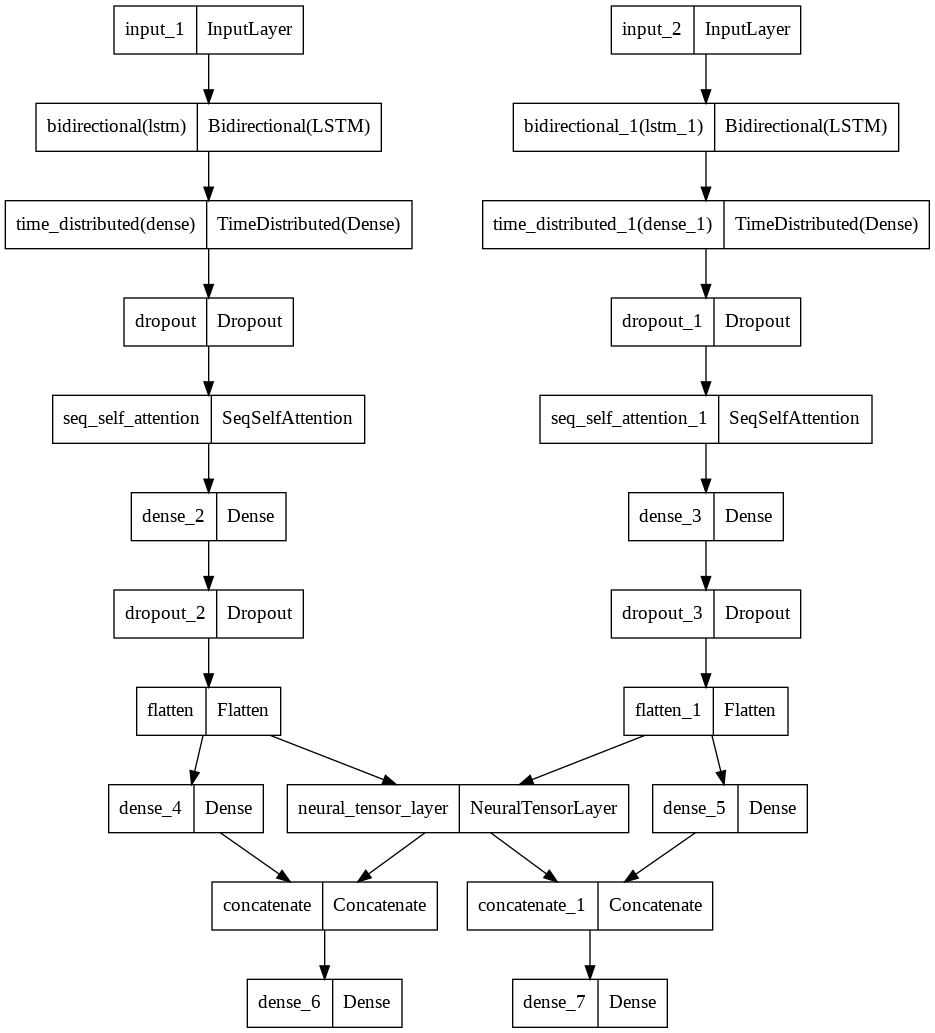

In [ ]:
from keras.utils import plot_model
plot_model(model)

In [ ]:
history=model.fit([pol_embs, subj_embs], [np.array(pol_labels), np.array(subj_labels)], batch_size=128, epochs=15, verbose=1, shuffle=True, validation_split=0.2)

Epoch 1/15
13/13 [==============================] - 41s 990ms/step - loss: 1.7368 - dense_6_loss: 0.9414 - dense_7_loss: 0.7612 - dense_6_acc: 0.5206 - dense_7_acc: 0.6394 - val_loss: 1.8583 - val_dense_6_loss: 1.2563 - val_dense_7_loss: 0.5683 - val_dense_6_acc: 0.0475 - val_dense_7_acc: 0.8200
Epoch 2/15
13/13 [==============================] - 10s 809ms/step - loss: 1.2897 - dense_6_loss: 0.8767 - dense_7_loss: 0.3799 - dense_6_acc: 0.5444 - dense_7_acc: 0.8637 - val_loss: 1.4128 - val_dense_6_loss: 1.0126 - val_dense_7_loss: 0.3678 - val_dense_6_acc: 0.0550 - val_dense_7_acc: 0.8625
Epoch 3/15
13/13 [==============================] - 10s 787ms/step - loss: 1.1394 - dense_6_loss: 0.8035 - dense_7_loss: 0.3041 - dense_6_acc: 0.5400 - dense_7_acc: 0.8819 - val_loss: 1.5732 - val_dense_6_loss: 1.2028 - val_dense_7_loss: 0.3393 - val_dense_6_acc: 0.0425 - val_dense_7_acc: 0.9125
Epoch 4/15
13/13 [==============================] - 10s 796ms/step - loss: 1.0860 - dense_6_loss: 0.7580 - de

In [ ]:
score = model.evaluate([pol_embs, subj_embs], [np.array(pol_labels), np.array(subj_labels)], verbose=1)
score

63/63 [==============================] - 8s 125ms/step - loss: 0.8905 - dense_6_loss: 0.7231 - dense_7_loss: 0.1459 - dense_6_acc: 0.5025 - dense_7_acc: 0.9575


[0.8905432820320129,
 0.7231073379516602,
 0.14593034982681274,
 0.5024999976158142,
 0.9574999809265137]

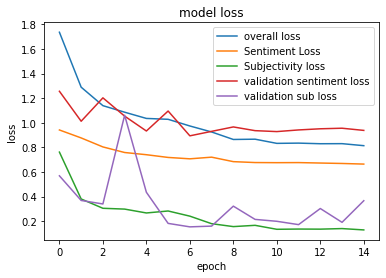

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['dense_6_loss'])
plt.plot(history.history['dense_7_loss'])
plt.plot(history.history['val_dense_6_loss'])
plt.plot(history.history['val_dense_7_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['overall loss','Sentiment Loss', 'Subjectivity loss','validation sentiment loss', 'validation sub loss'], loc='upper right')

plt.savefig(root+"Results/Loss_best.png")

plt.show()

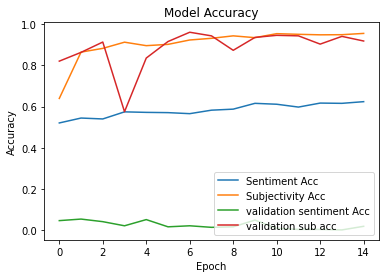

In [ ]:
plt.plot(history.history['dense_6_acc'])
plt.plot(history.history['dense_7_acc'])
plt.plot(history.history['val_dense_6_acc'])
plt.plot(history.history['val_dense_7_acc'])

plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Sentiment Acc', 'Subjectivity Acc','validation sentiment Acc', 'validation sub acc'], loc='lower right')

plt.savefig(root+"Results/Acc_best.png")
plt.show()

In [ ]:
model_json = model.to_json()
with open(root+"Results/model_bert.json", "w") as json_file:
    json_file.write(model_json)

NotImplementedError: ignored

### Unused

In [ ]:
from google.colab import files

files.upload()

In [ ]:
#from ntn_no_print import NeuralTensorNetwork

In [ ]:
#pol_emb = np.load(root + 'pol.npy')
#subj_emb = np.load(root + 'subj_obj.npy')

#pol_embs = np.load(root+'BERT/Polarity-Embeddings/bert_emb_pol_100.npy')
#for i in range(1,20):
#    tmp = np.load(root+f'BERT/Polarity-Embeddings/bert_emb_pol_{(i+1)*100}.npy')
#    print(f"iteration {i}\n")
#    print(f"len tmp {len(tmp)}\n")
#    pol_embs = np.concatenate((pol_embs,tmp))
#    print(f"len pol_embs {len(pol_embs)}\n")

In [ ]:
# first batch. When doing np.save everything is flatten up
# need to rebuild the features to have a list of 2k elements to spit up
print(pol_emb[:64])

In [ ]:
print(pol_emb[0].shape)

In [ ]:
pol_emb_arranged = []

for i in range(0,len(pol_emb)+1, 512):
    if i==0:
        chunk = pol_emb[:512]
    else:    
        chunk = pol_emb[i-512:i]
        pol_emb_arranged.append(chunk)

print(len(pol_emb_arranged))
#print(pol_emb_arranged)

In [ ]:
subj_emb_arranged = []

for i in range(0,len(pol_emb)+1, 512):
    if i==0:
        chunk = subj_emb[:512]
    else:    
        chunk = subj_emb[i-512:i]
        subj_emb_arranged.append(chunk)

print(len(subj_emb_arranged))
#print(pol_emb_arranged)

In [ ]:
import math
import torch.nn.functional as F

In [ ]:
def scaled_dot_product(q, k, v, mask=None):
    d_k = q.size()[-1]
    attn_logits = torch.matmul(q, k.transpose(-2, -1))
    attn_logits = attn_logits / math.sqrt(d_k)
    if mask is not None:
        attn_logits = attn_logits.masked_fill(mask == 0, -9e15)
    attention = F.softmax(attn_logits, dim=-1)
    values = torch.matmul(attention, v)
    return values, attention

In [ ]:
# https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial6/Transformers_and_MHAttention.html
class MultiheadAttention(nn.Module):

    def __init__(self, input_dim, embed_dim, num_heads):
        super().__init__()
        assert embed_dim % num_heads == 0, "Embedding dimension must be 0 modulo number of heads."

        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads

        # Stack all weight matrices 1...h together for efficiency
        self.qkv_proj = nn.Linear(input_dim, 3*embed_dim)
        self.o_proj = nn.Linear(embed_dim, embed_dim)

        self._reset_parameters()

    def _reset_parameters(self):
        # Original Transformer initialization, see PyTorch documentation
        nn.init.xavier_uniform_(self.qkv_proj.weight)
        self.qkv_proj.bias.data.fill_(0)
        nn.init.xavier_uniform_(self.o_proj.weight)
        self.o_proj.bias.data.fill_(0)

    def forward(self, x, mask=None, return_attention=False):
        batch_size, seq_length, _ = x.size()
        qkv = self.qkv_proj(x)

        # Separate Q, K, V from linear output
        qkv = qkv.reshape(batch_size, seq_length, self.num_heads, 3*self.head_dim)
        qkv = qkv.permute(0, 2, 1, 3) # [Batch, Head, SeqLen, Dims]
        q, k, v = qkv.chunk(3, dim=-1)

        # Determine value outputs
        values, attention = scaled_dot_product(q, k, v, mask=mask)
        values = values.permute(0, 2, 1, 3) # [Batch, SeqLen, Head, Dims]
        values = values.reshape(batch_size, seq_length, self.embed_dim)
        o = self.o_proj(values)

        if return_attention:
            return o, attention
        else:
            return o

### Steps to import python files in Collaboratory
- go to Google Drive where the Jupyter Notebook containing the desired functions to import is
- download it with the .py extension
- run the following cell to put it in the content space

In this particular case we would need to import as a module the NTN file, containing the Neural Tensor Network implementation

In [ ]:
class Attn(nn.Module):
    def __init__(self, method, hidden_size):
        super(Attn, self).__init__()
        self.method = method
        if self.method not in ['dot', 'general', 'concat']:
            raise ValueError(self.method, "is not an appropriate attention method.")
        self.hidden_size = hidden_size
        if self.method == 'general':
            self.attn = nn.Linear(self.hidden_size, hidden_size)
        elif self.method == 'concat':
            self.attn = nn.Linear(self.hidden_size * 2, hidden_size)
            self.v = nn.Parameter(torch.FloatTensor(hidden_size))

    def dot_score(self, hidden, encoder_output):
        return torch.sum(hidden * encoder_output, dim=2)

    def general_score(self, hidden, encoder_output):
        energy = self.attn(encoder_output)
        return torch.sum(hidden * energy, dim=2)

    def concat_score(self, hidden, encoder_output):
        energy = self.attn(torch.cat((hidden.expand(encoder_output.size(0), -1, -1), encoder_output), 2)).tanh()
        return torch.sum(self.v * energy, dim=2)

    def forward(self, hidden, encoder_outputs):
        # Calculate the attention weights (energies) based on the given method
        if self.method == 'general':
            attn_energies = self.general_score(hidden, encoder_outputs)
        elif self.method == 'concat':
            attn_energies = self.concat_score(hidden, encoder_outputs)
        elif self.method == 'dot':
            attn_energies = self.dot_score(hidden, encoder_outputs)

        # Transpose max_length and batch_size dimensions
        attn_energies = attn_energies.t()

        # Return the softmax normalized probability scores (with added dimension)
        return F.softmax(attn_energies, dim=1).unsqueeze(1)